<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/Trabalho_Final_Draft_Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Projeto Final - Mineração de Dados Complexos***

# 0) Setup

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.925062951999962
GPU (s):
0.048644264999893494
GPU speedup over CPU: 39x


In [3]:
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd
import pickle

import tensorflow as tf
from IPython.display import SVG
#import efficientnet.tfkeras as efn
from tensorflow.keras.utils import plot_model
import tensorflow.keras.layers as L
#from tensorflow.keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50V2

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cmx


tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

import os

# 1) Importando bases do kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ericsuda","key":"30d8265b6f81dcfb2bcba05081127ac4"}'}

In [5]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 58 kB 2.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=6ca8d8d72a5f2398f5eeedc7c85fe9390306961c8b279fe0706de0e1b2989f86
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
! mkdir projeto_final

In [7]:
! kaggle competitions download -c plant-pathology-2021-fgvc8 -p "projeto_final/"

100% 14.8G/14.9G [02:42<00:00, 194MB/s]
100% 14.9G/14.9G [02:42<00:00, 98.3MB/s]


In [8]:
!unzip "projeto_final/plant-pathology-2021-fgvc8.zip" -d "/projeto_final/"

Streaming output truncated to the last 5000 lines.
  inflating: /projeto_final/train_images/e00c97b2de4749ce.jpg  
  inflating: /projeto_final/train_images/e00df890cfe62736.jpg  
  inflating: /projeto_final/train_images/e00ed0bf43a87f25.jpg  
  inflating: /projeto_final/train_images/e00f759d65d52887.jpg  
  inflating: /projeto_final/train_images/e00f934d9e50ad5b.jpg  
  inflating: /projeto_final/train_images/e00fce341cb63da5.jpg  
  inflating: /projeto_final/train_images/e010c7c35ecf3d1c.jpg  
  inflating: /projeto_final/train_images/e01112939f783fec.jpg  
  inflating: /projeto_final/train_images/e01592da4d71b8be.jpg  
  inflating: /projeto_final/train_images/e0189acaf8cf80fd.jpg  
  inflating: /projeto_final/train_images/e0189e4999bdd0fa.jpg  
  inflating: /projeto_final/train_images/e01ae16d4a759cb5.jpg  
  inflating: /projeto_final/train_images/e01dc39ccb2b4ccb.jpg  
  inflating: /projeto_final/train_images/e01e42d90c66f3f3.jpg  
  inflating: /projeto_final/train_images/e01e870bec65

# 2) EDA

### 2.1) Carregando os datasets

In [9]:
TEST_PATH = "../projeto_final/sample_submission.csv"
TRAIN_PATH = "../projeto_final/train.csv"

In [49]:
df_train = pd.read_csv(TRAIN_PATH)
df_test=pd.read_csv(TEST_PATH)

In [50]:
df_train["labels"].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

#### Onehot Encoding

In [69]:
# Ajustando labels com onehot encoding

df_train["label_list"] = df_train["labels"].str.split(" ")

df_train.head()

,image,labels,label_list,healthy,scab,complex,rust,frog_eye_leaf_spot,powdery_mildew
0,800113bb65efe69e.jpg,healthy,[healthy],1,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]",0,1,1,0,1,0
2,80070f7fb5e2ccaa.jpg,scab,[scab],0,1,0,0,0,0
3,80077517781fb94f.jpg,scab,[scab],0,1,0,0,0,0
4,800cbf0ff87721f8.jpg,complex,[complex],0,0,1,0,0,0


In [ ]:
# Metodo 1 de oneohot ecoding

def onehot_label(col, label_list):
  if col in label_list:
    onehot = 1
  else:
    onehot = 0
  
  return onehot
  
label_list = df_train[df_train["label_list"].str.len() == 1]["labels"].unique()

for label in label_list:
  df_train[label] = 0

for label in label_list:
  df_train[label] = np.vectorize(onehot_label)(label, df_train["label_list"])

In [ ]:
# Metodo 2 onehot encoding

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_mlb = pd.DataFrame(mlb.fit_transform(df_train["label_list"]),columns=mlb.classes_)

# Apenas para validar ambos os jeitos
df_train.join(df_mlb, how="left", lsuffix="_first_method", rsuffix="_second_method").head()

### 2.2) Analise Exploratoria

In [158]:
plt.figure(figsize=(10,5))
df_plot = pd.DataFrame(df_plot).reset_index()

fig = px.bar(df_plot, x='index', y='labels')
fig.show()

<Figure size 720x360 with 0 Axes>

#### Analise Duplicados

In [14]:
! pip install imagehash

     |████████████████████████████████| 812 kB 5.3 MB/s 
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=8ae35b9a27402e186e860f09dac23554553ef350ba16d1cb85a3a5f6672c4da6
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built imagehash


In [15]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imagehash
import PIL
import os

In [16]:
class CFG():
    
    threshold = .9
    img_size = 512
    seed = 42

In [17]:
paths = os.listdir("/projeto_final/train_images/")

try:
  os.mkdir("/projeto_final/train_images_small")
except:
  pass

In [20]:
for path in tqdm(paths, total=len(paths)):
  image = tf.io.read_file(os.path.join("/projeto_final/train_images/", path))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [CFG.img_size, CFG.img_size])
  image = tf.cast(image, tf.uint8).numpy()
  plt.imsave("/projeto_final/train_images_small/"+path, image)

  0%|          | 0/18632 [00:00<?, ?it/s]

In [21]:
hash_functions = [
    imagehash.average_hash,
    imagehash.phash,
    imagehash.dhash,
    imagehash.whash]

image_ids = []
hashes = []

paths = tf.io.gfile.glob('/projeto_final/train_images_small/*.jpg')

for path in tqdm(paths, total=len(paths)):

    image = PIL.Image.open(path)

    hashes.append(np.array([x(image).hash for x in hash_functions]).reshape(-1,))
    image_ids.append(path.split('/')[-1])
    
hashes = np.array(hashes)
image_ids = np.array(image_ids)

  0%|          | 0/18632 [00:00<?, ?it/s]

In [22]:
duplicate_ids = []

for i in tqdm(range(len(hashes)), total=len(hashes)):
    similarity = (hashes[i] == hashes).mean(axis=1)
    duplicate_ids.append(list(image_ids[similarity > CFG.threshold]))
    
duplicates = [frozenset([x] + y) for x, y in zip(image_ids, duplicate_ids)]
duplicates = set([x for x in duplicates if len(x) > 1])



  0%|          | 0/18632 [00:00<?, ?it/s]

In [23]:
print(f'Found {len(duplicates)} duplicate pairs:')
for row in duplicates:
    print(', '.join(row))

Found 50 duplicate pairs:
83e3d2329933c5f2.jpg, 83e3d2369933c5d2.jpg
9ada65c5b0cc9a3c.jpg, e9e8ad35c5871d06.jpg
abb0d5a9d4b4985c.jpg, ab91d1a9d4b49a6c.jpg
d89c9cda9274322f.jpg, d89d9ede82743229.jpg
c9d63696629107ed.jpg, 8f5263c61a8cdbe2.jpg
aa542048ebf78bf4.jpg, aa142048eff78bf4.jpg
8c0731fff680c51e.jpg, df90901ccb664de6.jpg
e11be7f110de8f80.jpg, e13be7f1105e8f80.jpg
e51690d8ad307dcb.jpg, eec64e8cf1c8d0c6.jpg
d2266ac99461e9db.jpg, c1753cad2f31d492.jpg
a3bb604d8a55995d.jpg, e7ecc583d571d202.jpg
d0c766bc38e1978c.jpg, e83f715e56462a31.jpg
c738d13e7146798c.jpg, c738d13e73467988.jpg
98864714f96a75d5.jpg, 9886c704f93a79b3.jpg
90f99ee1c1132bb6.jpg, 94c83b2d5fad6924.jpg
a9b2e4b09297bc2b.jpg, d1f01e8d8a73274d.jpg
9fad869f21b5b240.jpg, d7ec32d72c84dc18.jpg
f6f1160be38a48d5.jpg, f6f11e0fe38a08c5.jpg
c5339e87235c6ac5.jpg, c53b9e87215c6ac5.jpg
c5aff2e545d0a129.jpg, dbee22785d9285c4.jpg
e22e9a365cd1ea58.jpg, e22e8a365cd1ea5c.jpg
f0cb859beb1b30c1.jpg, f0cb879e4a1b35c1.jpg
ca782c131f5ce0fc.jpg, e5f273

In [34]:
# Criando csv de duplicados e salvando no drive

with open("drive/MyDrive/projeto_final_dups.csv", "w") as file:
  for row in duplicates:
    file.write(";".join(row)+"\n")

In [39]:
df_dups = pd.read_csv("drive/MyDrive/projeto_final_dups.csv", sep=";", names=["img_1", "img_2"])

In [88]:
df_dups_cat = df_dups.merge(df_train[["image","label_list"]], left_on="img_1", right_on="image", how="left")
df_dups_cat.drop("image",axis = 1, inplace=True)
df_dups_cat.rename(columns={"label_list":"labels_1"},inplace=True)

In [89]:
df_dups_cat = df_dups_cat.merge(df_train[["image","label_list"]], left_on="img_2", right_on="image", how="left")
df_dups_cat.drop("image",axis = 1, inplace=True)
df_dups_cat.rename(columns={"label_list":"labels_2"},inplace=True)

In [94]:
df_dups_cat["flag_same_label"] = df_dups_cat["labels_1"] != df_dups_cat["labels_2"]

In [95]:
# Nem todas as imagens tem os mesmos labels associdos a elas
df_dups_cat["flag_same_label"].value_counts()

True     27
False    23
Name: flag_same_label, dtype: int64

In [96]:
df_dups_cat.head()

,img_1,img_2,labels_1,labels_2,flag_same_label
0,83e3d2329933c5f2.jpg,83e3d2369933c5d2.jpg,[scab],[scab],False
1,9ada65c5b0cc9a3c.jpg,e9e8ad35c5871d06.jpg,[complex],[rust],True
2,abb0d5a9d4b4985c.jpg,ab91d1a9d4b49a6c.jpg,[rust],[rust],False
3,d89c9cda9274322f.jpg,d89d9ede82743229.jpg,[rust],[rust],False
4,c9d63696629107ed.jpg,8f5263c61a8cdbe2.jpg,[complex],[rust],True


In [110]:
def ret_img(image_name, path:str):
  img = mpimage.imread(path + image_name)
  return img


def plot_duplicates(df_dup:pd.DataFrame, rownum:int, path:str)-> None:
  image_name_0 = df_dup["img_1"].loc[rownum]
  image_name_1 = df_dup["img_2"].loc[rownum]
  
  label_0 = df_dup["labels_1"].loc[rownum]
  label_1 = df_dup["labels_2"].loc[rownum]

  plt.figure(figsize=(9,4))
  plt.subplot(121)
  plt.imshow(ret_img(image_name_0 ,path= path))
  plt.title('{} - {}'.format(image_name_0, label_0))
  plt.subplot(122)
  #n = lst_img[1]
  plt.imshow(ret_img(image_name_1 ,path= path))
  plt.title('{} - {}'.format(image_name_1, label_1))
  plt.tight_layout()


Exception ignored in: <function tqdm.__del__ at 0x7fb7993a3c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


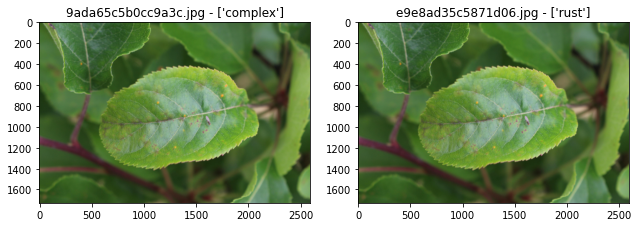

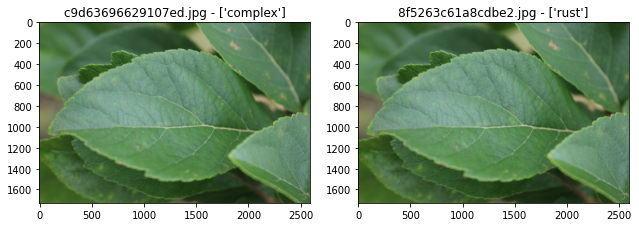

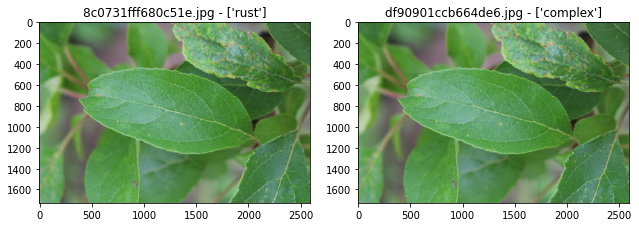

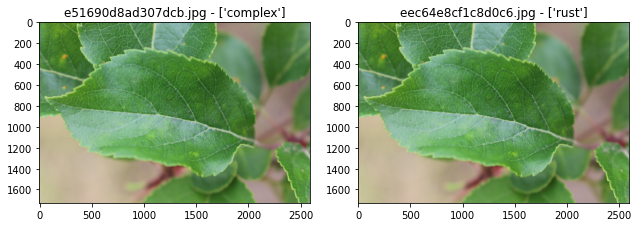

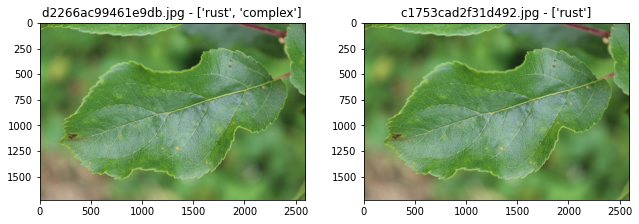

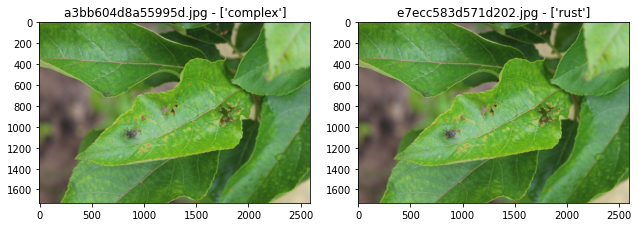

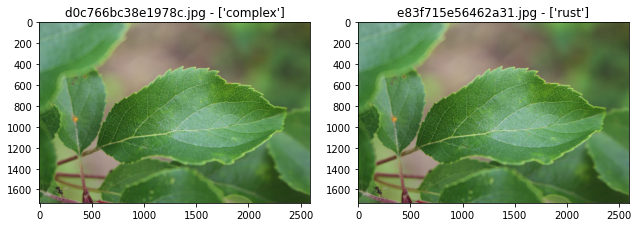

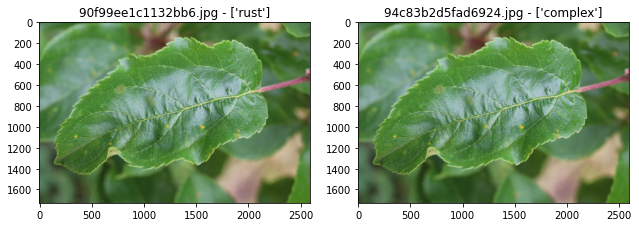

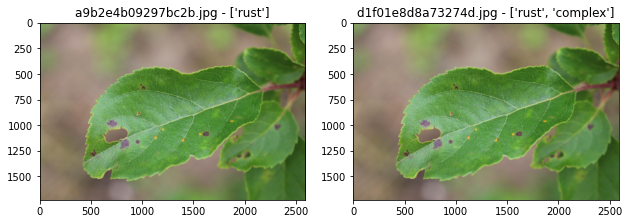

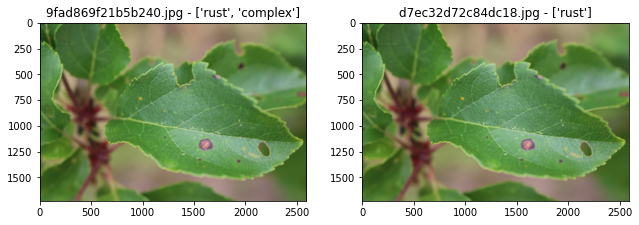

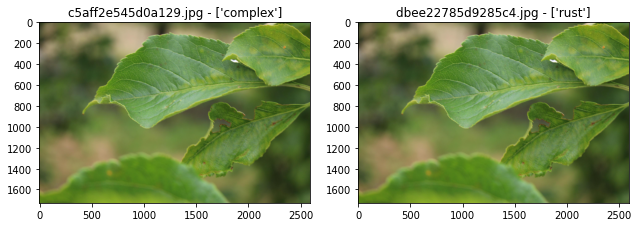

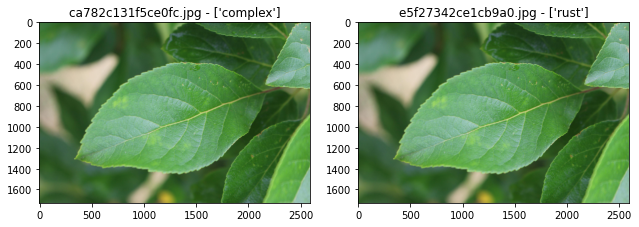

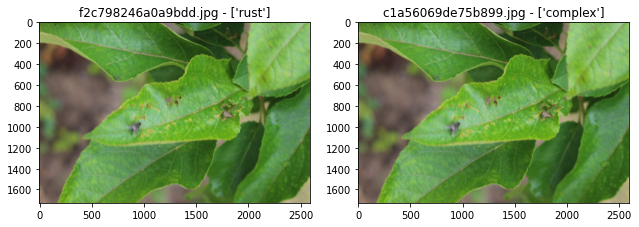

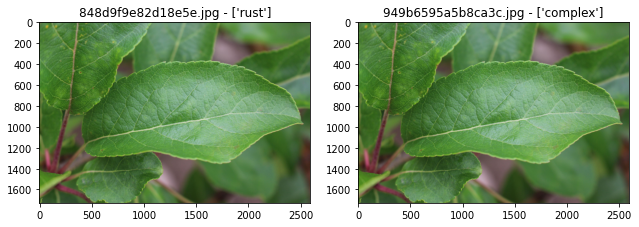

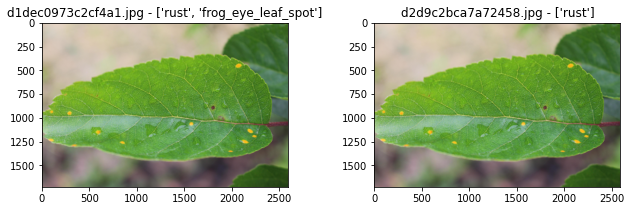

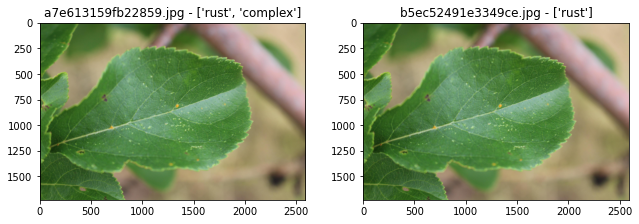

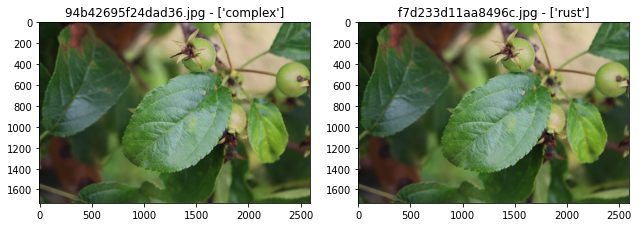

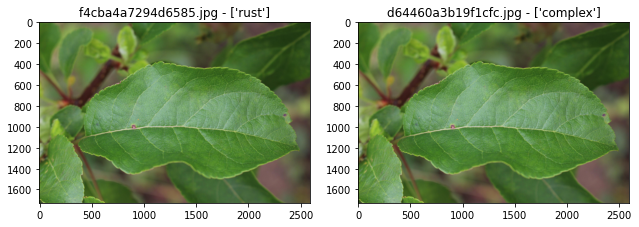

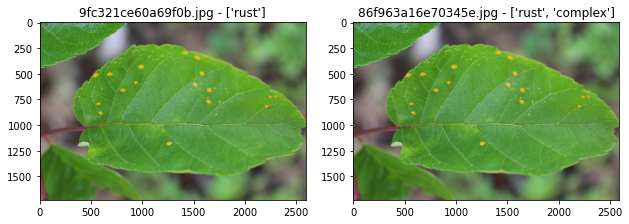

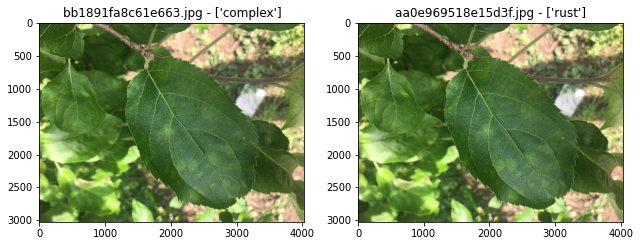

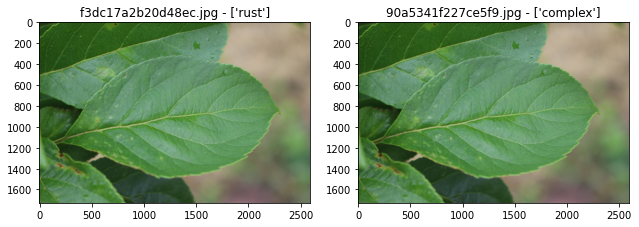

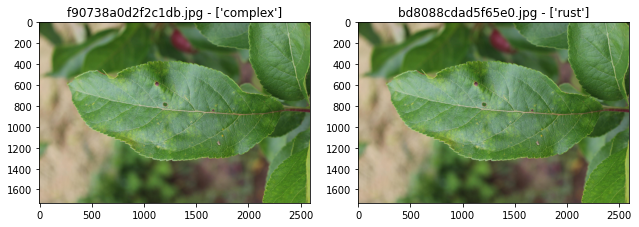

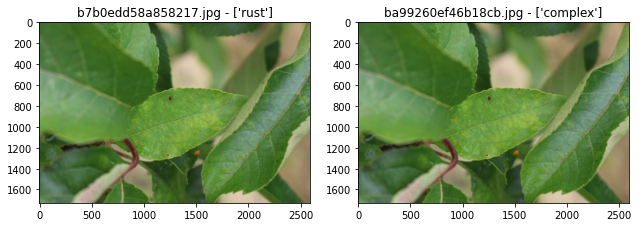

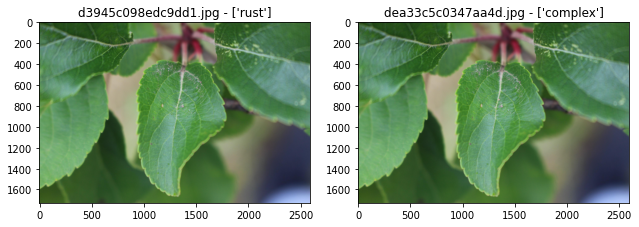

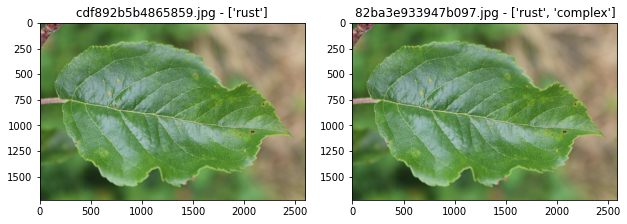

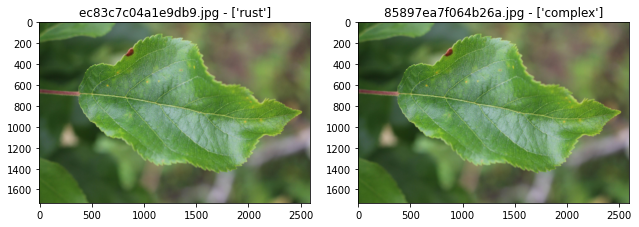

In [130]:
df_dups_diff = df_dups_cat[df_dups_cat["flag_same_label"]==True].reset_index(drop=True)
df_len = df_dups_diff.shape[0]
path = "../projeto_final/train_images/"

for rownum in range(df_len-1):
  plot_duplicates(df_dups_diff, rownum, path=path)

In [150]:
print("image_1")
df_dups_cat[df_dups_cat["flag_same_label"] == True]["labels_1"].str.join(sep=",").value_counts()

image_1


rust                       12
complex                    11
rust,complex                3
rust,frog_eye_leaf_spot     1
Name: labels_1, dtype: int64

In [151]:
print("image_2")
df_dups_cat[df_dups_cat["flag_same_label"] == True]["labels_2"].str.join(sep=",").value_counts()

image_2


rust            15
complex          9
rust,complex     3
Name: labels_2, dtype: int64

In [162]:
df_dups_cat["labels_1_str"] = df_dups_cat["labels_1"].str.join(sep=",")
df_dups_cat["labels_2_str"] = df_dups_cat["labels_2"].str.join(sep=",")

In [166]:
pd.DataFrame(df_dups_cat.groupby(["labels_1_str", "labels_2_str"])["flag_same_label"].count())

flag_same_label
labels_1_str            labels_2_str                       
complex                 complex                           1
                        rust                             11
frog_eye_leaf_spot      frog_eye_leaf_spot                1
rust                    complex                           9
                        rust                             18
                        rust,complex                      3
rust,complex            rust                              3
rust,frog_eye_leaf_spot rust                              1
scab                    scab                              3

In [ ]:
#-------- Alternativa 1 --------
# Tratamento 1 de imagens Duplicadas
# Aquelas que tem a mesma classe apenas irei pegar apenas uma delas por distinct
# As que tem labels diferentes serao removidos do dataset (total de 27 imagens - penalizamos bem a classe Rust, Complex)